In [8]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import csv

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
from scipy import optimize
from pylab import *


In [9]:
path = '/srv/home/chenyu/DEbackup/2019/082519/S8/'

# Load HAADF file
file_HAADF = [image for image in os.listdir(path) if '_Preview' in image]
file_HAADF = file_HAADF[0]
with open(path +  file_HAADF) as csvfile:
    file=csv.reader(open(path+file_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(200,200))
# HAADFarray = HAADFarray[0:200,:]
im = HAADFarray
im = scipy.ndimage.gaussian_filter(HAADFarray,2)

# Refine positions of peaks
image_max = ndi.maximum_filter(im, size=8, mode='constant')
coordinates = peak_local_max(im, min_distance=5)

peaks_x_fit = []
peaks_y_fit = []

peaks_x_fit = coordinates[:,1]
peaks_y_fit = coordinates[:,0]

# for i in range(coordinates.shape[0]):
    
#     x = int(coordinates[i][1])
#     y = int(coordinates[i][0])
    
#     if x >=7 and y>=7:
#         patch = im[y-6:y+6,x-6:x+6]
#         patch = patch - amin(patch)
#         bg = 0

#         # parameters are in the order of : background, height, cx, cy, wx, wy
#         guess = (bg,patch[6,6]-bg,6, 6, 3, 3)
#         bounds = ([0,0,0,0,1,1],[np.inf,np.inf,10,10,10,10])
#         param = fitGaussianx2(patch, guess, bounds)

#         peaks_x_fit.append(param[2]+x-4)
#         peaks_y_fit.append(param[3]+y-4)
    


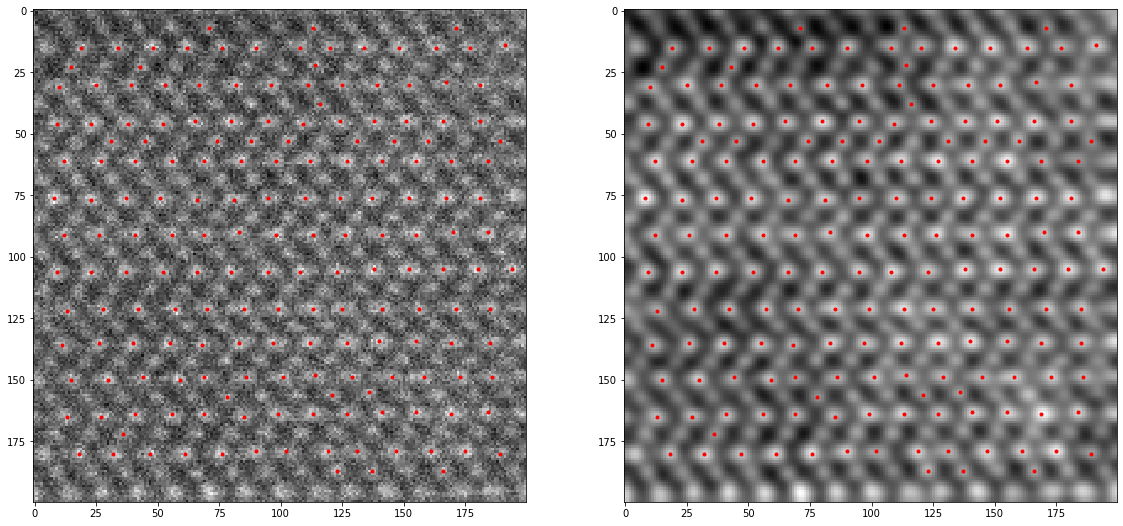

In [10]:

fig = plt.figure(figsize=(30,10))
fig.add_subplot(1,3,1)
plt.imshow((HAADFarray), cmap='gray')
# plt.axis('off')
plt.plot(coordinates[:,1], coordinates[:,0],'r.')

fig.add_subplot(1,3,2)
plt.imshow(im, cmap='gray')
# plt.axis('off')
plt.plot(peaks_x_fit, peaks_y_fit,'r.')

peaks_x_fit = coordinates[:,1]
peaks_y_fit = coordinates[:,0]


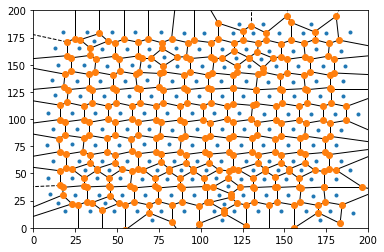

181

In [38]:
# Build Voroni cells
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(np.transpose(np.asarray([peaks_x_fit, peaks_y_fit])))
voronoi_plot_2d(vor)
plt.xlim([0,200])
plt.ylim([0,200])
plt.show()

len(vor.regions)

In [234]:
# Refine detected Voroni polygons, remove all the ones that contains border, i.e. vor.regions contain -1, empty cell, 
# cell with negative border, cell with border over pixel range

i = 0
while i != len(vor.regions):
    if -1 in vor.regions[i] or not vor.regions[i] or not all(vor.vertices[vor.regions[i]]>0) or not all(vor.vertices[vor.regions[i]]<369):
        del vor.regions[i]
    else:
        i = i+1
    

In [235]:
# Extract pixels within each Voroni cell
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Very inefficient way to loop over all Voroni polygons for each pixel
# Not sure how to quickly find all pixels within each polygon
# https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
# Construct nx-by-ny px image with integers, each integer marks a voroni polygon

voroni_idx = np.zeros((200,200))

for irow in range(200):
    for icol in range(200):
        point = Point(icol,irow) # shapely.geomerty.Point is in the order of (x,y), thus (icol, irow)
        for ipolygon in range(len(vor.regions)):
            
            # vor.regions contains indices of points that form the polygon
            # vor.vertices contains coordinates of all points that are used to form Voroni polygons
            polygon = Polygon(vor.vertices[vor.regions[ipolygon]])
            
            if polygon.contains(point) is True:
                
                voroni_idx[irow,icol] = ipolygon+1
        

In [236]:
# Recalculate COM shift with symmetric ROI from reference point
# Real space scan grid size
num_rows = 200
num_cols = 200
# Reconstruct a BF image to check whether it matches HAADF
BF = np.zeros((num_rows,num_cols))
# Reciprocal space image size
rx = 200
ry = 200
kx = 512
ky = 512
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)
ref = np.load('/srv/home/chenyu/DEbackup/082519/BlankCOM_14.5MX.npy')
ExpName = 'S5'
COM_exp = np.zeros((num_rows,num_cols,2))
for irow in range(rx):
    for icol in range(ry):
        filenum = irow*num_cols+icol+1
        ref_x = ref[irow,icol,0]
        ref_y = ref[irow,icol,1]
        mask = create_circular_mask(512,512, center=[ref_x,ref_y], radius=min(ref_x,ref_y,511-ref_x,511-ref_y))
        frame = np.load(path+'npy/'+ExpName+'_'+format(filenum,'05')+'.npy')
        COM_exp[irow,icol,0] = np.average(weights_x,weights = frame*mask)
        COM_exp[irow,icol,1] = np.average(weights_y,weights = frame*mask)
        BF[irow,icol] = np.sum(frame*mask)

COM_exp = COM_exp - ref
np.save(path + 'COM_refine.npy',COM_exp)

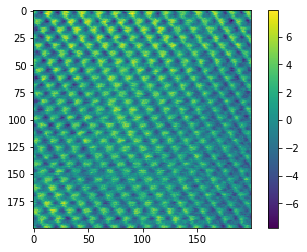

In [237]:
plt.imshow(COM_exp[:,:,0])
plt.colorbar()

In [68]:
sin(rot)

0.14780941112961063

In [11]:
# np.save(path + 'Voroni_cell_map.npy', voroni_idx)
# COM_exp = np.load(path + 'COM_refine.npy')
voroni_idx = np.load(path + 'Voroni_cell_map.npy')
COM_exp = np.load(path + 'COM_refine.npy')
rx = 200
ry = 200
# Extract momentum transfer and real space COM for each voroni polygon
# For this dataset, diffraction x-y is almost aligned with image edges, thus COM movement along x,y can be directly interpreted as polar

# Save information of each Voroni polgon inside a n-by-4 matrix, each row contains cx, cy, COMx, COMy
voroni_list = np.zeros((int(np.amax(voroni_idx)), 4))
voroni_x = np.zeros((rx,ry))
voroni_y = np.zeros((rx,ry))
rot = 8.5 # rotation in degrees, counter-clockwise as positive, following python setting
rot = math.radians(rot)
for i in range(int(np.amax(voroni_idx))):
    pixels = np.where(voroni_idx == i+1)
    voroni_list[i,0] = np.average(pixels[0])   # row index
    voroni_list[i,1] = np.average(pixels[1])   # col index
    voroni_list[i,2] = np.average(COM_exp[pixels[0],pixels[1],0]) # along x
    voroni_list[i,3] = np.average(COM_exp[pixels[0],pixels[1],1]) # along y
    
    voroni_list[i,2] = np.average(COM_exp[pixels[0],pixels[1],0]*cos(rot)-COM_exp[pixels[0],pixels[1],1]*sin(rot)) # along kx
    voroni_list[i,3] = np.average(COM_exp[pixels[0],pixels[1],1]*cos(rot)+COM_exp[pixels[0],pixels[1],0]*sin(rot)) # along ky
    
#     voroni_list[i,2] = np.average(ref[pixels[0],pixels[1],0]-np.average(ref[:,:,0]))  # row, col, kx
#     voroni_list[i,3] = np.average(ref[pixels[0],pixels[1],1]-np.average(ref[:,:,1]))  # row, col, ky
    
    voroni_x[pixels] = voroni_list[i,2]
    voroni_y[pixels] = voroni_list[i,3]

(14.367559523809522, 195.4201388888889, 21.64370700459546, 192.99843197326277)

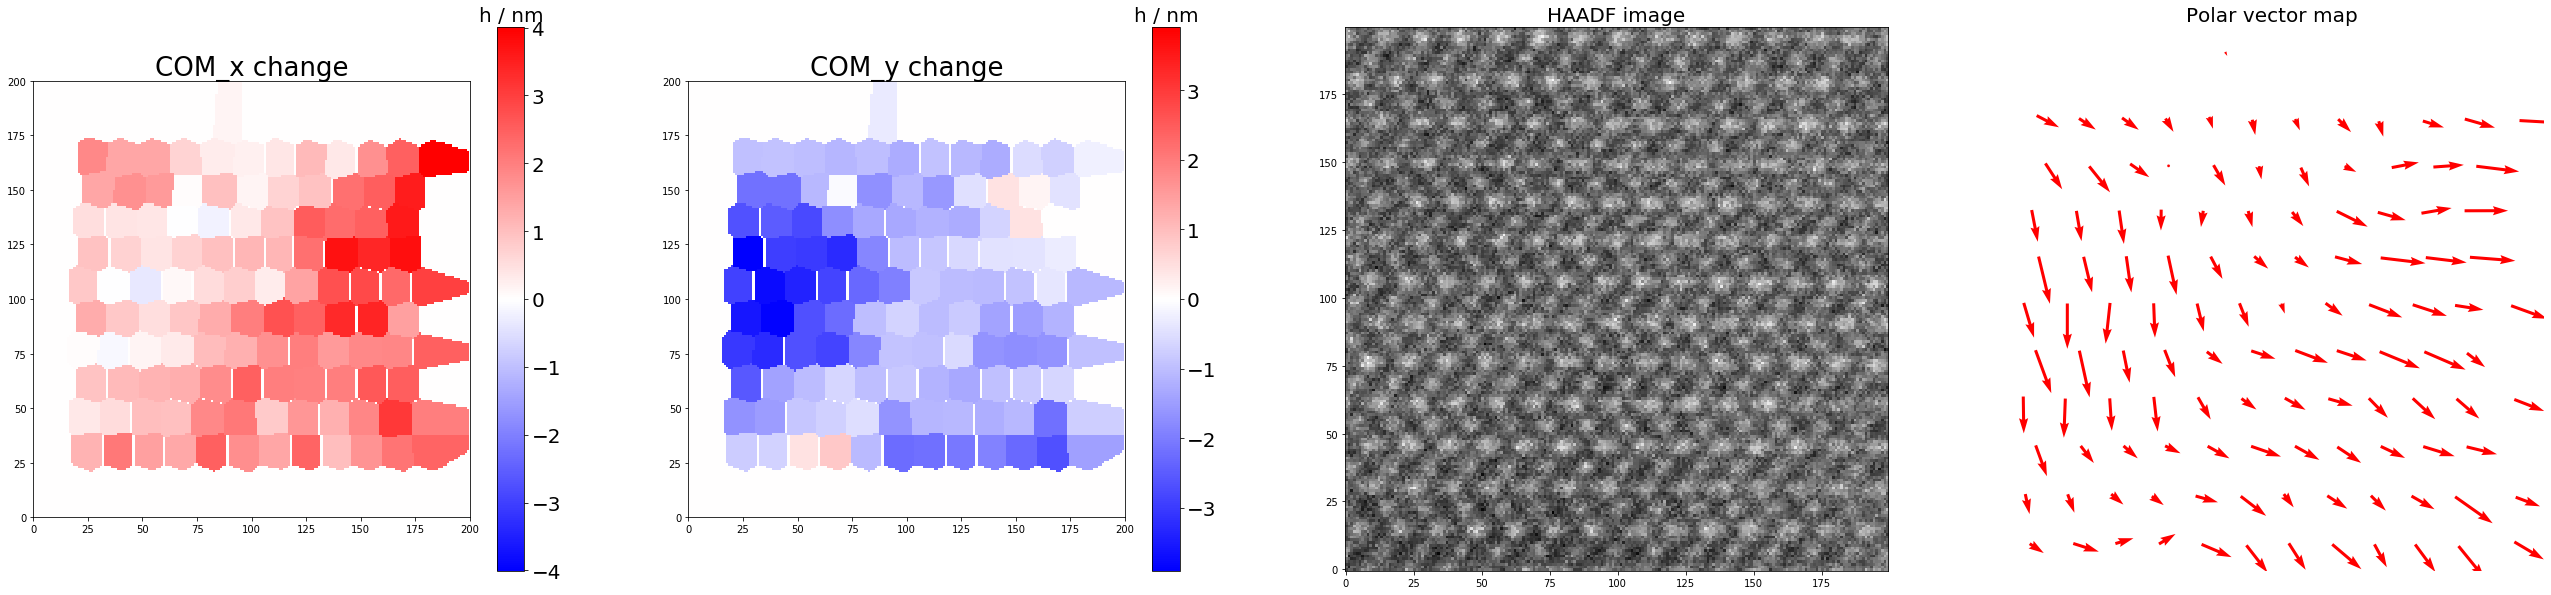

In [12]:
fig = plt.figure(figsize=(45,10))
fig.add_subplot(1,4,1)
plt.imshow(voroni_x  * 0.147 * 0.4* 13.70,cmap=plt.cm.bwr,clim=[-amax(abs(voroni_x* 0.147 * 0.4* 13.70)),amax(abs(voroni_x* 0.147 * 0.4* 13.70))])
# plt.clim([-3* 0.147 * 0.4,3* 0.147 * 0.4])
plt.title('COM_x change',fontsize=26)
plt.xlim([0,200])
plt.ylim([0,200])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('h / nm', fontsize = 20)
# plt.axis('off')

fig.add_subplot(1,4,2)
plt.imshow(voroni_y *0.147 * 0.4* 13.70,cmap=plt.cm.bwr,clim=[-amax(abs(voroni_y* 0.147 * 0.4* 13.70)),amax(abs(voroni_y* 0.147 * 0.4* 13.70))])
plt.title('COM_y change',fontsize=26)
# plt.clim([-3* 0.147 * 0.4,3* 0.147 * 0.4])
plt.xlim([0,200])
plt.ylim([0,200])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('h / nm', fontsize = 20)
# plt.axis('off')

fig.add_subplot(1,4,3)
plt.imshow(HAADFarray,cmap='gray',origin='lower')
plt.title('HAADF image',fontsize=20)
# plt.axis('off')
# plt.scatter(peaks_x_fit, peaks_y_fit)
# plt.imshow(np.flipud(np.transpose(HAADFarray)),cmap='gray')
# plt.scatter(np.asarray(peaks_y_fit),149-np.asarray(peaks_x_fit))

fig.add_subplot(1,4,4)
plt.quiver(voroni_list[:,1], voroni_list[:,0], voroni_list[:,2], voroni_list[:,3],color='r')
plt.title('Polar vector map', fontsize=20)
plt.axis('off')

In [45]:
rx = 200
ry = 200
ExpName = 'S8'
PACBED = np.zeros((512,512))
for irow in range(rx):
    for icol in range(ry):
        filenum = irow*ry+icol+1
        frame = np.load(path+'npy/'+ExpName+'_'+format(filenum,'05')+'.npy')
        PACBED = PACBED + frame

(-0.5, 511.5, 511.5, -0.5)

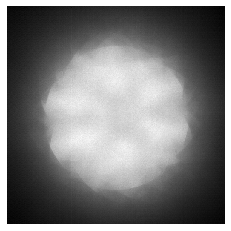

In [46]:
plt.imshow(PACBED,cmap='gray')
plt.axis('off')

In [5]:
def gaussianx2(xdata_tuple,bg,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()

In [6]:
def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt

In [7]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [13]:
# Extract a single stripe

# np.save(path + 'Voroni_cell_map.npy', voroni_idx)
# COM_exp = np.load(path + 'COM_refine.npy')
voroni_idx = np.load(path + 'Voroni_cell_map.npy')
COM_exp = np.load(path + 'COM_refine.npy')
rx = 200
ry = 200
# Extract momentum transfer and real space COM for each voroni polygon
# For this dataset, diffraction x-y is almost aligned with image edges, thus COM movement along x,y can be directly interpreted as polar

# Save information of each Voroni polgon inside a n-by-4 matrix, each row contains cx, cy, COMx, COMy
voroni_list = np.zeros((int(np.amax(voroni_idx)), 4))
voroni_x = np.zeros((rx,ry))
voroni_y = np.zeros((rx,ry))
rot = 8.5 # rotation in degrees, counter-clockwise as positive, following python setting
rot = math.radians(rot)
for i in range(int(np.amax(voroni_idx))):
    pixels = np.where(voroni_idx == i+1)
    voroni_list[i,0] = np.average(pixels[0])   # row index
    voroni_list[i,1] = np.average(pixels[1])   # col index
        
    if voroni_list[i,1] < 80:
        voroni_list[i,2] = np.average(COM_exp[pixels[0],pixels[1],0]) # along x
        voroni_list[i,3] = np.average(COM_exp[pixels[0],pixels[1],1]) # along y

        voroni_list[i,2] = np.average(COM_exp[pixels[0],pixels[1],0]*cos(rot)-COM_exp[pixels[0],pixels[1],1]*sin(rot)) # along kx
        voroni_list[i,3] = np.average(COM_exp[pixels[0],pixels[1],1]*cos(rot)+COM_exp[pixels[0],pixels[1],0]*sin(rot)) # along ky

        voroni_x[pixels] = voroni_list[i,2]
        voroni_y[pixels] = voroni_list[i,3]

(0.0, 100.0, 0.0, 200.0)

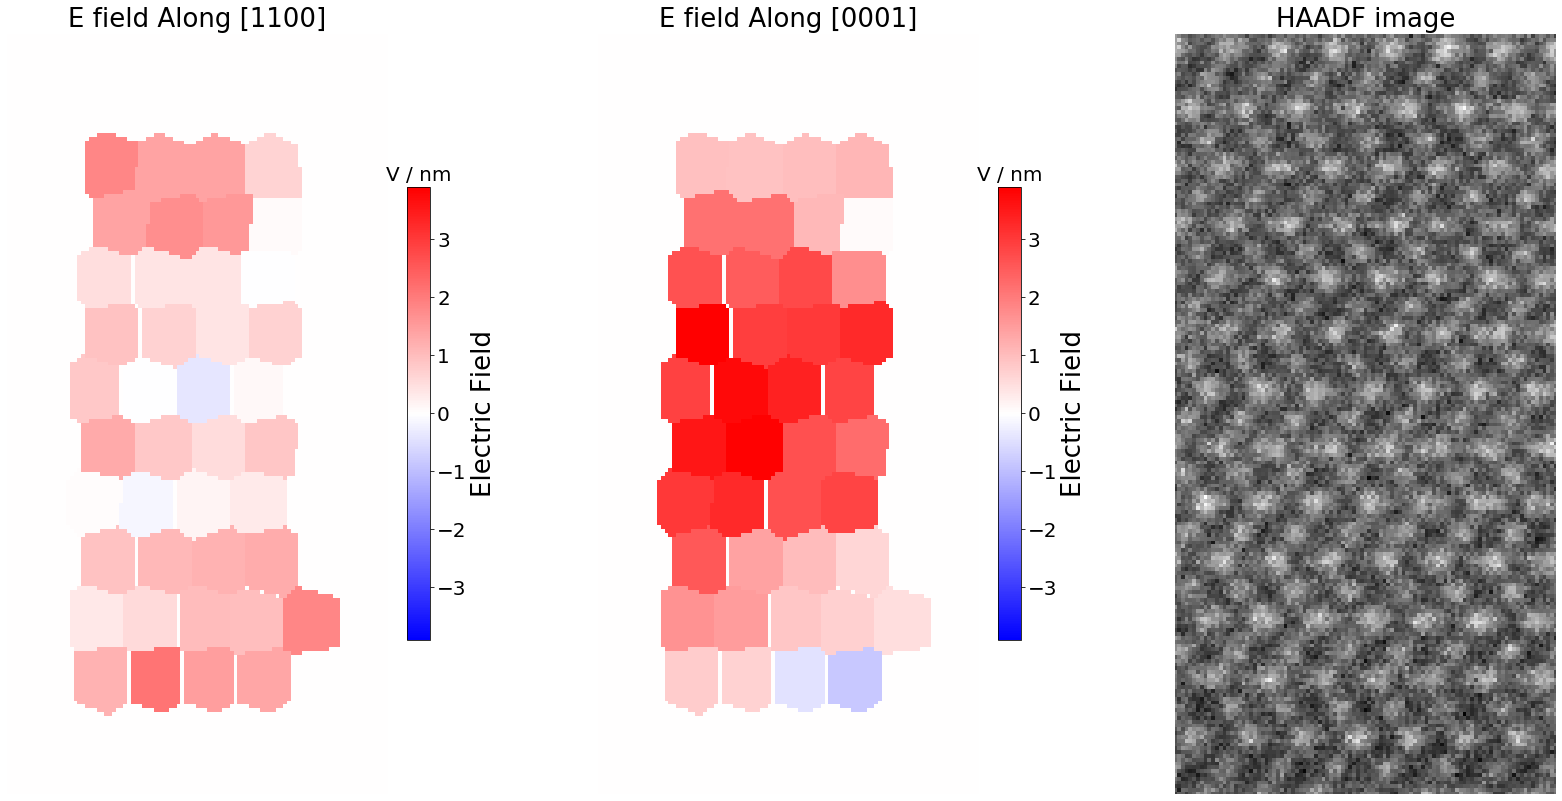

In [15]:
fig = plt.figure(figsize=(30,14))
fig.add_subplot(1,3,1)
im0 = plt.imshow(voroni_x  * 0.147 * 0.4* 13.70,cmap=plt.cm.bwr,origin='lower')
plt.clim([-amax(abs(voroni_y* 0.147 * 0.4* 13.70)),amax(abs(voroni_y* 0.147 * 0.4* 13.70))])
plt.title('COM_x change',fontsize=26)
plt.xlim([0,100])
plt.ylim([0,200])
plt.title('E field Along [1100]',fontsize=26)
cbar = plt.colorbar(im0, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('V / nm', fontsize = 20)
cbar.ax.set_ylabel('Electric Field',fontsize = 26)
plt.axis('off')

fig.add_subplot(1,3,2)
im0 = plt.imshow(-voroni_y *0.147 * 0.4* 13.70,cmap=plt.cm.bwr,origin='lower')
plt.clim([-amax(abs(voroni_y* 0.147 * 0.4* 13.70)),amax(abs(voroni_y* 0.147 * 0.4* 13.70))])
plt.xlim([0,100])
plt.ylim([0,200])
plt.title('E field Along [0001]',fontsize=26)
cbar = plt.colorbar(im0, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('V / nm', fontsize = 20)
cbar.ax.set_ylabel('Electric Field',fontsize = 26)
plt.axis('off')

fig.add_subplot(1,3,3)
plt.imshow(HAADFarray,cmap='gray',origin='lower')
plt.title('HAADF image',fontsize=26)
plt.xlim([0,100])
plt.ylim([0,200])
plt.axis('off')

# fig.add_subplot(1,4,4)
# plt.quiver(voroni_list[:,1], voroni_list[:,0], voroni_list[:,2], voroni_list[:,3],color='r')
# plt.title('Polar vector map', fontsize=20)
# plt.axis('off')

In [18]:
np.mean(voroni_y *0.147 * 0.4* 13.70)

-0.41889129459414515